In [1]:
import numpy as np
import pandas as pd
import tqdm
%matplotlib inline
from datetime import time
from pylab import mpl, plt
import seaborn as sns

In [21]:
ar = np.zeros((11, 11))
ar[0, ] = [0, 1, 2, 3, 4, 4, 3, 2, 1, 1, 0]
ar[1, ] = [1, 0, 1, 3, 4, 4, 4, 3, 2, 1, 0]
ar[2, ] = [2, 1, 0, 2, 3, 4, 5, 4, 3, 2, 0]
ar[3, ] = [3, 3, 2, 0, 2, 4, 5, 6, 5, 3, 1]
ar[4, ] = [4, 4, 3, 2, 0, 2, 5, 7, 7, 5, 2]
ar[5, ] = [4, 4, 4, 4, 2, 0, 3, 7, 9, 8, 4]
ar[6, ] = [3, 4, 5, 5, 5, 3, 0, 5, 9, 11, 8]
ar[7, ] = [2, 3, 4, 6, 7, 7, 5, 0, 8, 15, 15]
ar[8, ] = [1, 2, 3, 5, 7, 9, 9, 8, 0, 15, 30]
ar[9, ] = [1, 1, 2, 3, 5, 8, 11, 15, 15, 0, 61]
ar[10, ] = [0, 0, 0, 1, 2, 4, 8, 15 ,30, 61, 0]


In [76]:
# print(ar[8, 10])

In [22]:
datafile = '/home/sash/Python/projects/mlfin/data/Volatility 25 Index_M5_201901010500_202110151455.csv'
data = pd.read_csv(datafile,
                 encoding='utf-8',
                 index_col=False,
                 skiprows=1,
                 header= None,
                 names= ['date', 'time','open','high', 'low', 'close', 'tv', 'vol', 'spread'],
                 sep='\t')
data['datetime'] = data['date'] + ' ' + data['time']

data.reset_index(drop=True, inplace=True)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')
data.drop(['date', 'time', 'tv', 'vol', 'spread'], axis= 1, inplace=True)


In [23]:
data['can_type'] = np.where(
    data['open'] != data['close'],
    np.sign(data['close'] - data['open']), 1)

In [24]:
# Задаем начальные значения
begin_balance = 100
stake = 0.4
balance = 0
percent_profit = 0.90

# Время начала торговой сессии - часы, минуты
begin_hour = 18
begin_minute = 0
# Определяем новые столбцы
data['trade'] = 0
data['pay'] = 0
data['trade_result'] = 0
data['balance'] = 0.00

data['tim_beg'] = np.where((data.index.time == time(begin_hour, begin_minute)), True, False)

time_begin = data.columns.get_loc('tim_beg')
trade_c = data.columns.get_loc('trade')
can_type_c = data.columns.get_loc('can_type')
pay_c = data.columns.get_loc('pay')
trade_result_c = data.columns.get_loc('trade_result')
balance_c = data.columns.get_loc('balance')
data['koef'] = '0'
koef_c = data.columns.get_loc('koef')
first_trade = True
print(time_begin)
ai = 0
aj = 0
# data.head(15)

9


In [25]:
first_trade = True
not_trade = (ai == 11 or aj == 11) or (ai != aj and ar[ai, aj] == 0)
#not_trade = (ai != aj and ar[ai, aj] == 0)
data.iloc[0, balance_c] = begin_balance
ai = 0
aj = 0
for i in tqdm.trange (len(data)): # 20010 #(len(data/2)):
    
    if i > 0:
        data.iloc[i, balance_c] = data.iloc[i-1, balance_c]
    #not_trade = (ai != aj and ar[ai, aj] == 0)
    
    not_trade = (ai == 11 or aj == 11) or (ai != aj and ar[ai, aj] == 0)
    if (data.iloc[i, time_begin] == True) & (first_trade == True):
        first_trade = False 
        # Определяем первоначальное изменение коэф массива
        # Если предыдущая свеча была черной - в массиве сдвигаемся вниз
        if data.iloc[i-1, can_type_c] == -1:
            data.iloc[i, trade_c] = -1
            ai +=1
            data.iloc[i, pay_c] = ar[ai, aj]
            #ai = 1, aj = 0
            #data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)

        # Если предыдущая свеча была белой - сдвигаемся вправо
        elif data.iloc[i-1, can_type_c] == 1:
            data.iloc[i, trade_c] = 1
            aj += 1
            data.iloc[i, pay_c] = ar[ai, aj]
            #ai = 0, aj = 1
        data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)

        
        if data.iloc[i, can_type_c] == data.iloc[i, trade_c]: #win
            data.iloc[i, trade_result_c] = 1
            data.iloc[i, balance_c] = data.iloc[i-1, balance_c] + data.iloc[i, pay_c] * stake * (percent_profit)
            data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)
            if ai > aj: # мы на стороне Put-ов
                ai += 1
            else: # мы на стороне Call-ов
                aj += 1
            
        elif data.iloc[i, can_type_c] != data.iloc[i, trade_c]: # Loss
            data.iloc[i, trade_result_c] = -1 
            data.iloc[i, balance_c] = data.iloc[i-1, balance_c] + data.iloc[i, pay_c] * stake * data.iloc[i, trade_result_c]
            data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)
            if ai > aj: # мы на стороне Put-ов
                aj += 1
            else: # мы на стороне Call-ов
                ai += 1
        
        balance = data.iloc[i, balance_c]
        #data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)
        continue

    
    if (first_trade == False and not_trade == False):
        # Заполняем trade и pay
        if ai == aj:
            data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)
            data.iloc[i, trade_c] == 0
            data.iloc[i, pay_c] == ar[ai, aj]
            data.iloc[i, balance_c] = data.iloc[i-1, balance_c]

            if data.iloc[i-1, trade_c] == 1:
                ai += 1
            if data.iloc[i-1, trade_c] == -1:
                aj += 1  
            continue

        if ai > aj : #пошли в сторону Put- ов, т.е. вниз и вправо
            data.iloc[i, trade_c] = -1
            data.iloc[i, pay_c] = ar[ai, aj]
            data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)

            if data.iloc[i, trade_c] == data.iloc[i, can_type_c]: # Win
                data.iloc[i, trade_result_c] = 1
                data.iloc[i, balance_c] = data.iloc[i-1, balance_c] + data.iloc[i, pay_c] * stake * (percent_profit)
                ai += 1
            elif data.iloc[i, trade_c] != data.iloc[i, can_type_c]: # Loss
                data.iloc[i, trade_result_c] = -1
                data.iloc[i, balance_c] = data.iloc[i-1, balance_c] + data.iloc[i, pay_c] * stake * data.iloc[i, trade_result_c]
                aj += 1
            #data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)4 6
            
        if ai < aj :#пошли в сторону Call -ов
            data.iloc[i, trade_c] = 1
            data.iloc[i, pay_c] = ar[ai, aj]
            data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)
            if data.iloc[i, trade_c] == data.iloc[i, can_type_c]: # Win
                data.iloc[i, trade_result_c] = 1
                data.iloc[i, balance_c] = data.iloc[i-1, balance_c] + data.iloc[i, pay_c] * stake * (percent_profit)
                aj += 1
            elif data.iloc[i, trade_c] != data.iloc[i, can_type_c]: # Loss
                data.iloc[i, trade_result_c] = -1
                data.iloc[i, balance_c] = data.iloc[i-1, balance_c] + data.iloc[i, pay_c] * stake * data.iloc[i, trade_result_c]
                ai += 1
            #data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)

    if not_trade == True:
        ai = 0
        aj = 0
        first_trade = True
        
        
        
    
    #first_trade = False
    #data.iloc[i, koef_c] = str(ai) + '  ' + str(aj)
    
                
        
            
                
        
# Проверить выполнение = сперва присваиваем значения ai aj, а потом ставим 'pay'
# или наоборот - сперва присваивать pay, а потом ai aj4 6


data.head(30)       

100%|██████████| 293206/293206 [13:54<00:00, 351.45it/s]


,open,high,low,close,can_type,trade,pay,trade_result,balance,tim_beg,koef
datetime,,,,,,,,,,,
2019-01-01 05:00:00,3366.717,3367.419,3365.395,3365.834,-1.0,0,0,0,100.0,False,0
2019-01-01 05:05:00,3365.666,3369.929,3364.820,3369.762,1.0,0,0,0,100.0,False,0
2019-01-01 05:10:00,3369.845,3370.854,3367.432,3368.314,-1.0,0,0,0,100.0,False,0
2019-01-01 05:15:00,3368.104,3370.402,3367.767,3369.761,1.0,0,0,0,100.0,False,0
2019-01-01 05:20:00,3369.583,3371.964,3369.141,3371.229,1.0,0,0,0,100.0,False,0
2019-01-01 05:25:00,3370.758,3374.884,3370.307,3373.811,1.0,0,0,0,100.0,False,0
2019-01-01 05:30:00,3374.061,3374.485,3370.478,3370.478,-1.0,0,0,0,100.0,False,0
2019-01-01 05:35:00,3370.492,3372.589,3368.709,3369.683,-1.0,0,0,0,100.0,False,0
2019-01-01 05:40:00,3369.746,3372.520,3369.062,3369.977,1.0,0,0,0,100.0,False,0


In [18]:
data.head(20000).to_csv('/home/sash/Python/projects/mlfin/data/data_in/data_balance_check.csv')

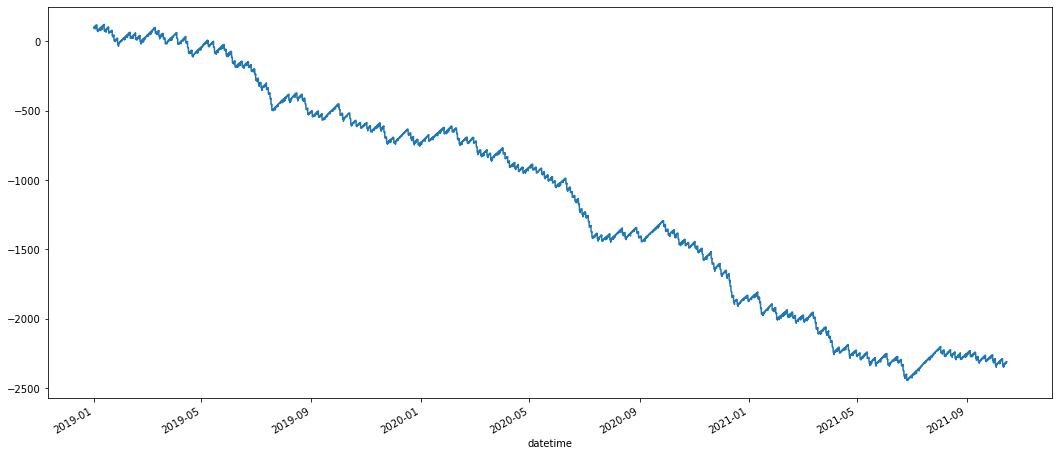

In [26]:
# data['balance'][0:20000,].plot(figsize = (18, 8));
#
data['balance'].plot(figsize = (18, 8));

In [20]:
data['balance'][0:20000,].tail()
# data['balance'].tail()

datetime
2019-03-11 15:15:00    58.64
2019-03-11 15:20:00    58.64
2019-03-11 15:25:00    58.64
2019-03-11 15:30:00    58.64
2019-03-11 15:35:00    58.64
Name: balance, dtype: float64

In [19]:
data['balance'].describe()

count    293206.000000
mean       8989.850799
std        5003.070609
min          96.320000
25%        4570.610000
50%        9101.440000
75%       12995.240000
max       17998.680000
Name: balance, dtype: float64

In [36]:
b = np.zeros((1,2))

In [37]:
print(b)

[[0. 0.]]


In [39]:
np.append(b, [[1, 15]], axis=0)

array([[ 0.,  0.],
       [ 1., 15.]])

In [27]:
print(b)

[[0 0]]
